# Exact diagonalization study of 1/2 Heisenberg chain by Lanczos algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import csv

In [ ]:
# set parameters
N=8
dimension=2**N
#spin chain with all spin-down
z='0'*N
# initialize hamiltonian
H=np.zeros((dimension,dimension))
z

'00000000'

In [ ]:
# Matrix Construction
for a in range(dimension):
    state_chain=bin(a)[2:] # the first two should be omitted for this 'bin' function
    l=len(state_chain)
    state_chain=z[0:N-l]+state_chain # make the length equal to N
    #print(state_chain)
  # for PBC, we set i in range(N)
  # for OBC, we set i in range(N-1)
    for i in range(N):
        j=np.mod(i+1,N)
        if state_chain[i]==state_chain[j]: # i=j only diagonal elements
            H[a,a]+=0.25
        else: # else, the raising/lowering operators also have contributions
            H[a,a]-=0.25
            # then exchange i,j
            element_i=state_chain[i]
            element_j=state_chain[j]
            #flip
            if j==0:
#here we are doing the concatenation of string (you can try other methods)
#                    print(state_chain)
                state_chain1=element_i+state_chain[1:N-1]+element_j
            else:
                state_chain1=state_chain[0:i]+element_j+element_i+state_chain[j+1:]
            b=int(state_chain1,2)
            H[a,b]+=0.5

# Lanczos algorithm

This note utilises the [Wikipedia on the algorithm](https://en.wikipedia.org/wiki/Lanczos_algorithm).

Our Hamiltonian $H$ is a matrix of size $n\times n$, we want to simplify it to a tridiagonal matrix $T$ of size $m\times m$.

The steps are the given as:

1. for an arbitray complex vector $\nu_1=(\nu^1_1, \nu^2_1,\cdots,\nu^n_1)$ with norm $\langle \nu_1 |\nu_1\rangle=1$.
Let's do
$$
\begin{aligned}
\omega'_1 &= H \nu_1 \\
\alpha_1 &= \langle \omega'_1 | \nu_1\rangle \\
\omega_1 &= \omega'_1 - \alpha_1\nu_1
\end{aligned}
$$
<font color="red">(did you notice the Gram-Schmidt process?)
$$
\begin{aligned}
\nu_2 &= \frac{1}{\beta_2}(H\nu_1-\alpha_1\nu_1)\\
\langle \nu_2 | \nu_2 \rangle &= \frac{\langle \omega_1| \omega_1 \rangle}{\langle \omega_1 | \omega_1 \rangle}=1 \\
\langle \nu_1|\nu_2\rangle &= \frac{1}{\beta_2}(\langle \nu_1 | H|\nu_1\rangle-\langle\nu_1|\alpha_1|\nu_1\rangle) =0.
\end{aligned}
$$
</font>

2. for $j=2,\cdots,m$, do
      1. $\beta_j = \sqrt{\langle\omega_{j-1}|\omega_{j-1}\rangle}$
      2. $\nu_j = \omega_{j-1}/\beta_j$
      3. $\omega'_j = H\nu_j-\beta_j \nu\_{j-1}$
      4. $\alpha_j=\langle\omega'_j|\nu_j\rangle$
      5. $\omega_j=\omega'_j-\alpha_j \nu_j$

<font color="red">Such that
$$
\begin{aligned}
\nu_3 &= \frac{1}{\beta_3}(H\nu_{2}-\beta_{2}\nu_{1}-\alpha_{2}\nu_{2}) \\
&\cdots \\
\nu_j &= \frac{1}{\beta_j}(H\nu_{j-1}-\beta_{j-1}\nu_{j-2}-\alpha_{j-1}\nu_{j-1})\\
\langle \nu_{j-1}|\nu_j\rangle &= \frac{1}{\beta_j}(\langle \nu_{j-1} | H|\nu_{j-1}\rangle-\beta_{j-1}\langle \nu_{j-1}|\nu_{j-2}\rangle - \langle\nu_{j-1}|\alpha_{j-1}|\nu_{j-1}\rangle) \\
&=\frac{1}{\beta_j}(\langle \nu_{j-1}|H|\nu_{j-1}\rangle -\beta_{j-1}\langle\nu_{j-1}|\nu_{j-2}\rangle - \langle \nu_{j-1}|H|\nu_{j-1}\rangle - \beta_{j-1}\langle \nu_{j-1}|\nu_{j-2}\rangle)\\
&=0
\end{aligned}
$$
</font>

3. We generate the tridiagonal matrix $T$
$$
T= \begin{pmatrix}
\alpha_1 & \beta_2 & 0 & 0 & \cdots & 0 \\
\beta_2 & \alpha_2 & \beta_3 & 0 & \cdots & 0 \\
0 & \beta_3 & \alpha_3 & \beta_4  & \ddots & 0 \\
0 & 0 & \ddots & \ddots & \beta_{m-1} & 0 \\
0 & 0 & \cdots & \beta_{m-1} & \alpha_{m-1}& \beta_m \\
0 & 0 & \cdots & \cdots & \beta_m & \alpha_m
\end{pmatrix}
$$

One sees that a $n\times m$ matrix of $V=(\nu_1,\nu_2,\cdots,\nu_m)$ is formed with orthonormal columns and $H\nu_j = \beta_{j+1}\nu_{j+1}+\alpha_j\nu_j+\beta_j\nu_{j-1}$.

The relation between $n\times n$ Hamiltonian matrix $H$ and the $m\times m$ tridiagonal matrix $T$ is that
$$
T=V^{\dagger} H V.
$$

In [ ]:
def random_orthogonal(V,j):
    N = V.shape[0]
    v = np.random.randn(N)+1j*np.random.randn(N)
    for i in range(j):
        u = V[:,i]
        v -= np.vdot(u,v)*u/np.vdot(u,u)
    v = v/np.linalg.norm(v)
    return v
def Lanczos(Hamiltonian):
    H = np.copy(Hamiltonian)
    N = H.shape[0]
    m = min(40,N)
    H = 0.5*(H + H.conj().T)  # ensure Hermitian
    V_matrix = np.zeros((N, m), dtype=complex)
    T = np.zeros((m, m), dtype=complex)
    # init
    v = np.random.randn(N) + 1j*np.random.randn(N)
    v /= np.linalg.norm(v)
    V_matrix[:, 0] = v

    w_prime = H @ v
    alpha = np.vdot(v, w_prime)
    w = w_prime - alpha * v
    T[0, 0] = alpha

    for i in range(1, m):
#        if (i+1)%(m//10) == 0:
#            percent = int((i+1)/m*100)
#            print(f"Lanczos Progress:{percent}%")
#        h = V_matrix[:, :i].conj().T @ w
#        w -= V_matrix[:, :i] @ h
        beta = np.linalg.norm(w)
        v_old = v
        if beta < 10e-6:
            v = random_orthogonal(V_matrix,i)
        else:
            v = w / beta
        V_matrix[:, i] = v
        w_prime = H @ v - beta * v_old
        alpha = np.vdot(v, w_prime)
        w = w_prime - alpha * v

        T[i, i] = alpha
        T[i, i-1] = beta
        T[i-1, i] = beta

    return T




# Implicitly Shifted QR Decomposition Method to solve the eigenvalues of tridiagonal matrix

Algorithm 4 from the book: [Handbook of Linear Algebra by Hogben](https://math.ecnu.edu.cn/~jypan/Teaching/MC/refs/2014%20Symmetric%20Matrix%20Eigenvalue%20Techniques.pdf)




In [ ]:
def Givens(x,y):
    G = np.zeros([2,2])
    if y == 0:
        c = 1
        s = 0
    elif x == 0:
        c = 0
        s = np.sign(y)
    else:
        c = abs(x)/math.sqrt(abs(x)**2+abs(y)**2)
        s = np.sign(x)*y/math.sqrt(abs(x)**2+abs(y)**2)
    G[0,0] = c
    G[1,1] = c
    G[0,1] = s
    G[1,0] = -s
    return G

def QR_iteration(T_matrix):
    T = np.copy(T_matrix)
    T = np.real(T)
    epsilon = 10e-6
    if T.shape == (1,1):
        return T
    n_itr = 0

    while True:
        n_itr += 1
        N = T.shape[0]

        tau = (T[N-2,N-2]-T[N-1,N-1])/2
        sgn = np.copysign(1.0,tau)
        den = tau + sgn * np.sqrt(tau*tau+T[N-1,N-2]**2)
        if den == 0:
            mu = T[N-1,N-1]
        else:
            mu = T[N-1,N-1]-T[N-1,N-2]**2/den

        for i in range(0,N-1):
            if i==0:
                G = Givens(T[0,0]-mu,T[1,0])
            else:
                G = Givens(T[i,i-1],T[i+1,i-1])

            iL = max(i-1,0)
            iR = min(N,i+3)

            T[i:i+2,iL:iR] = G@T[i:i+2,iL:iR]
            T[iL:iR,i:i+2] = T[iL:iR,i:i+2]@G.T

            if abs(T[i,i+1])**2 <= epsilon**2*abs(T[i,i]*T[i+1,i+1]):
                #print(n_itr)
                T[i,i+1] = T[i+1,i] = 0.0
                T[0:i+1,0:i+1] = QR_iteration(T[0:i+1,0:i+1])
                T[i+1:N,i+1:N] = QR_iteration(T[i+1:N,i+1:N])
                return T



## The quesiton of gaust states


- The Lanczos vectors gradually lose their orthogonality as the iterations proceed.

- This loss of orthogonality leads to the appearance of multiple, nearly identical copies of the same eigenvector (ghost states) in the calculated spectrum, which are not related to the actual physical multiplicity of the eigenvalues.

- To manage or eliminate ghost states, methods like complete reorthogonalization (at every step) or partial reorthogonalization of the Lanczos vectors are used, although this increases computational cost. Alternative approaches in specific applications, such as using Matrix Product States (MPS) in density-matrix renormalization group (DMRG) methods, also aim to address the ghost problem.

In [ ]:
T = Lanczos(H)
print('')
print("diagonalize T with linalg.eig")
eig_v=np.real(np.linalg.eig(T)[0])
eig_v=np.sort(eig_v)
print("Lanczos eigenvalues: ", len(eig_v))
print(eig_v)
print('')

print("diagonalize T with homemade QR")
Lambda = QR_iteration(T)
eigs_lan = np.diag(Lambda)
eigs_lan = np.sort(eigs_lan)
print("Lanczos eigenvalues: ", len(eigs_lan))
print(eigs_lan)


diagonalize T with linalg.eig
Lanczos eigenvalues:  40
[-3.65109341e+00 -3.65109330e+00 -3.12841906e+00 -3.12010636e+00
 -2.69962815e+00 -2.45873851e+00 -2.14514837e+00 -1.85463768e+00
 -1.80193774e+00 -1.70710678e+00 -1.61803399e+00 -1.26703510e+00
 -1.20163963e+00 -1.14412274e+00 -9.99999039e-01 -8.58900769e-01
 -7.57425828e-01 -6.39243792e-01 -6.07364102e-01 -5.12323561e-01
 -4.39975510e-01 -2.94367661e-01 -2.58692367e-01 -3.52165308e-08
  2.65434619e-01  2.92875135e-01  3.77160928e-01  4.36991509e-01
  4.51584123e-01  6.18033986e-01  8.92693358e-01  1.00000000e+00
  1.14412281e+00  1.24697960e+00  1.33005874e+00  1.44572599e+00
  1.46050487e+00  1.52568712e+00  1.70710678e+00  2.00000000e+00]

diagonalize T with homemade QR
Lanczos eigenvalues:  40
[-3.65109341e+00 -3.65109330e+00 -3.12841906e+00 -3.12010636e+00
 -2.69962815e+00 -2.45873851e+00 -2.14514837e+00 -1.85463768e+00
 -1.80193773e+00 -1.70710678e+00 -1.61803399e+00 -1.26703510e+00
 -1.20163963e+00 -1.14412275e+00 -9.99999

In [ ]:
eig_value_H=np.real(np.linalg.eig(H)[0])
eig_value_H = np.sort(eig_value_H)
print("Total eigenvalues: ", len(eig_value_H))
print(eig_value_H)

Total eigenvalues:  256
[-3.65109341e+00 -3.12841906e+00 -3.12841906e+00 -3.12841906e+00
 -2.69962815e+00 -2.45873851e+00 -2.45873851e+00 -2.45873851e+00
 -2.45873851e+00 -2.45873851e+00 -2.45873851e+00 -2.14514837e+00
 -2.14514837e+00 -2.14514837e+00 -2.14514837e+00 -2.14514837e+00
 -2.14514837e+00 -1.85463768e+00 -1.85463768e+00 -1.85463768e+00
 -1.85463768e+00 -1.85463768e+00 -1.85463768e+00 -1.80193774e+00
 -1.80193774e+00 -1.80193774e+00 -1.80193774e+00 -1.80193774e+00
 -1.70710678e+00 -1.70710678e+00 -1.61803399e+00 -1.61803399e+00
 -1.26703510e+00 -1.26703510e+00 -1.26703510e+00 -1.26703510e+00
 -1.26703510e+00 -1.26703510e+00 -1.26703510e+00 -1.26703510e+00
 -1.26703510e+00 -1.26703510e+00 -1.20163968e+00 -1.20163968e+00
 -1.20163968e+00 -1.14412281e+00 -1.14412281e+00 -1.14412281e+00
 -1.14412281e+00 -1.14412281e+00 -1.14412281e+00 -1.14412281e+00
 -1.14412281e+00 -1.14412281e+00 -1.14412281e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -8.58923550e-01 -8.58923550e-01
 

# Combining the Lanczos with Magnetization Conservation and Translational Symmetry

In [ ]:
# set parameters
N=20
dimension=2**N
#spin chain with all spin-down
z='0'*N
method=1

In [ ]:
energy = {}
states = {}
for state in range(dimension):
    chain_here = bin(state)[2:]
    num_spinup = chain_here.count('1')

    if num_spinup not in states:
        states[num_spinup] = []

    states[num_spinup].append(state)

for spin_up in range(0,N+1):
    print('number of spin_up:', spin_up)
    if spin_up not in energy:
        energy[spin_up] = {}
    for m in range(0,N):
        print('momentum:', m)
        d = 0
        R_list = []
        state_list = []
        for state in states[spin_up]:
            chain_here = bin(state)[2:]
            length = len(chain_here)
            chain_here = z[0:N-length]+chain_here
            for ii in range(1,N+1):

                chain_here = chain_here[N-1] + chain_here[0:N-1]
                state_t = int(chain_here,2)
                if state_t < state:
                    break
                if state_t == state:
                    if np.mod(m*ii,N) == 0:
                        d = d+1
                        R_list.append(ii)
                        state_list.append(state)
                        break
                    else:
                        break

        Hm = np.zeros((d,d),dtype='complex')
        for a in range(d):
            for j in range(N):
                k = np.mod(j+1,N)
                s_a = bin(state_list[a])[2:]
                chain_m = z[0:N-len(s_a)]+s_a
                if chain_m[j] == chain_m[k]:
                    Hm[a,a] += 1/4
                else:
                    Hm[a,a] -= 1/4
                    chain_new = copy.deepcopy(chain_m)
                    element_j = chain_new[j]
                    element_k = chain_new[k]
                    if method==0:
                        if k==0:
                            chain_new = element_j + chain_new[1:N-1] + element_k
                        else:
                            chain_new=chain_new[0:j]+element_k+element_j+chain_new[k+1:]
                        r=int(chain_new,2)
                        t=copy.deepcopy(chain_new)
                    else: # using the .join way to exchange the k and j
                        chain1=list(chain_new)
                        chain1[j]=element_k
                        chain1[k]=element_j
                        r=int(''.join(chain1),2)
                        t=copy.deepcopy(''.join(chain1))
                    l = 0
                    for iii in range(1,N):
                        t = t[N-1] + t[0:N-1]
                        s_t = int(t,2)
                        if s_t < r:
                            r = s_t
                            l = iii
                    if r in state_list:
                        b = state_list.index(r)
                        Hm[a,b]+=0.5*np.sqrt(R_list[a]/R_list[b])*np.exp(-1j*2*np.pi*m*l/N) # off-diagonal

        if Hm.size == 0:
          print("Hamiltonian matrix Hm is empty. Skipping Lanczos.")
        else:
          #Lambda = QR_iteration(Lanczos(Hm))
          #eig_v = np.diag(Lambda)
          #eig_v = np.sort(eig_v)
          eig_v = np.real(np.linalg.eig(Lanczos(Hm))[0])
          energy[spin_up][m] = eig_v

number of spin_up: 0
momentum: 0
momentum: 1
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 2
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 3
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 4
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 5
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 6
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 7
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 8
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 9
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 10
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 11
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 12
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 13
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 14
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 15
Hamiltonian matrix Hm is empty. Skipping Lanczos.
momentum: 16
Hamiltonian matrix

In [ ]:
len(energy[10][10])

40

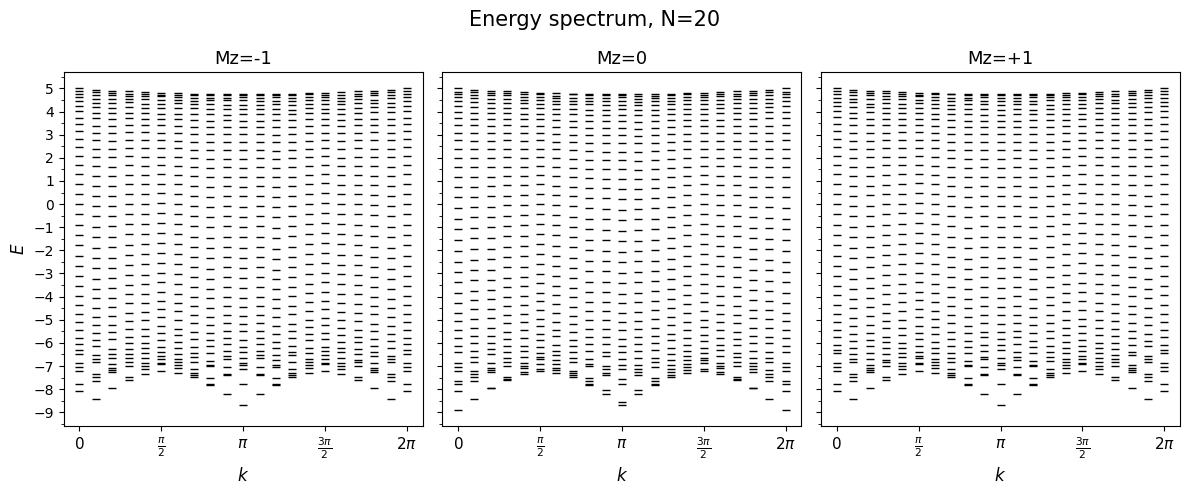

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spin_ups = [N//2 - 1, N//2, N//2 + 1]
Mz_vals = np.array(spin_ups) - N//2
titles = [f'Mz={val:+d}' if val > 0 else f'Mz={val:d}' for val in Mz_vals]

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for ax, su, title in zip(axes, spin_ups, titles):
    if su not in energy:
        ax.set_title(title + ' (no data)')
        ax.set_xlabel(r'$k$', fontsize=12)
        continue

    # Prepare data for plotting
    k_points = []
    e_points = []

    for m, eigs in energy[su].items():
        k_val = 2 * np.pi * m / N
        k_points.extend([k_val] * len(eigs))
        e_points.extend(eigs)

        # Duplicate k=0 data at 2π position
        if k_val == 0:
            k_points.extend([2 * np.pi] * len(eigs))
            e_points.extend(eigs)

    # Plot all points
    ax.scatter(k_points, e_points, marker='_', color='black', linewidth=1)

    ax.set_title(title, fontsize=13)
    ax.set_xlabel(r'$k$', fontsize=12)
    ax.set_xlim(-0.3, 2*np.pi + 0.3)
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\frac{\pi}{2}$', r'${\pi}$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=11)

    ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))

axes[0].set_ylabel(r'$E$', fontsize=12)
fig.suptitle(f'Energy spectrum, N={N}', fontsize=15)
plt.tight_layout()
plt.show()